In [27]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import nn

sys.path.append("..")


import src.main.delta_v_dqn.agent as agent
import src.main.delta_v_dqn.delta_v_dqn as dqn
import src.tools.diffusion.black_scholes as bs
import src.tools.option.option_main_class as option

In [28]:
strike = 40
r = 0.06
vol = 0.4
spot = 36
maturity = 1

# last_bias = 1/2
list_weights = [30,10]
activation_function = nn.ReLU()
n_simulation = 50
epsilon = 9
epsilon_decay = 0.01
epsilon_min = 0.01
learning_rate = 1e-2
d = 1
batch_size = 64
replay_memory_init = 64
replay_memory_capacity = 100000
N_update = 100

In [29]:
myagent = agent.Agent(
    epsilon,
    epsilon_decay,
    epsilon_min,
    replay_memory_init,
    replay_memory_capacity,
    N_update,
    learning_rate,
    batch_size,
    activation_function,
    list_weights,
    d,
)

process = bs.BlackScholes(spot, r, vol)
put_option_payoff = lambda x: max(strike - x, 0)
option_ = option.Option(maturity, strike, r, put_option_payoff)


dqn_object = dqn.delta_v_dqn(process, option_, myagent)

In [30]:
episodes_train = 3000
start_training = 500


(
    myagent,
    losses,

    reward_train,
    pos_train,
    sigma,
) = dqn_object.train(n_simulation, episodes_train, start_training, disable=False)

training


100%|██████████| 3000/3000 [00:48<00:00, 62.23it/s]


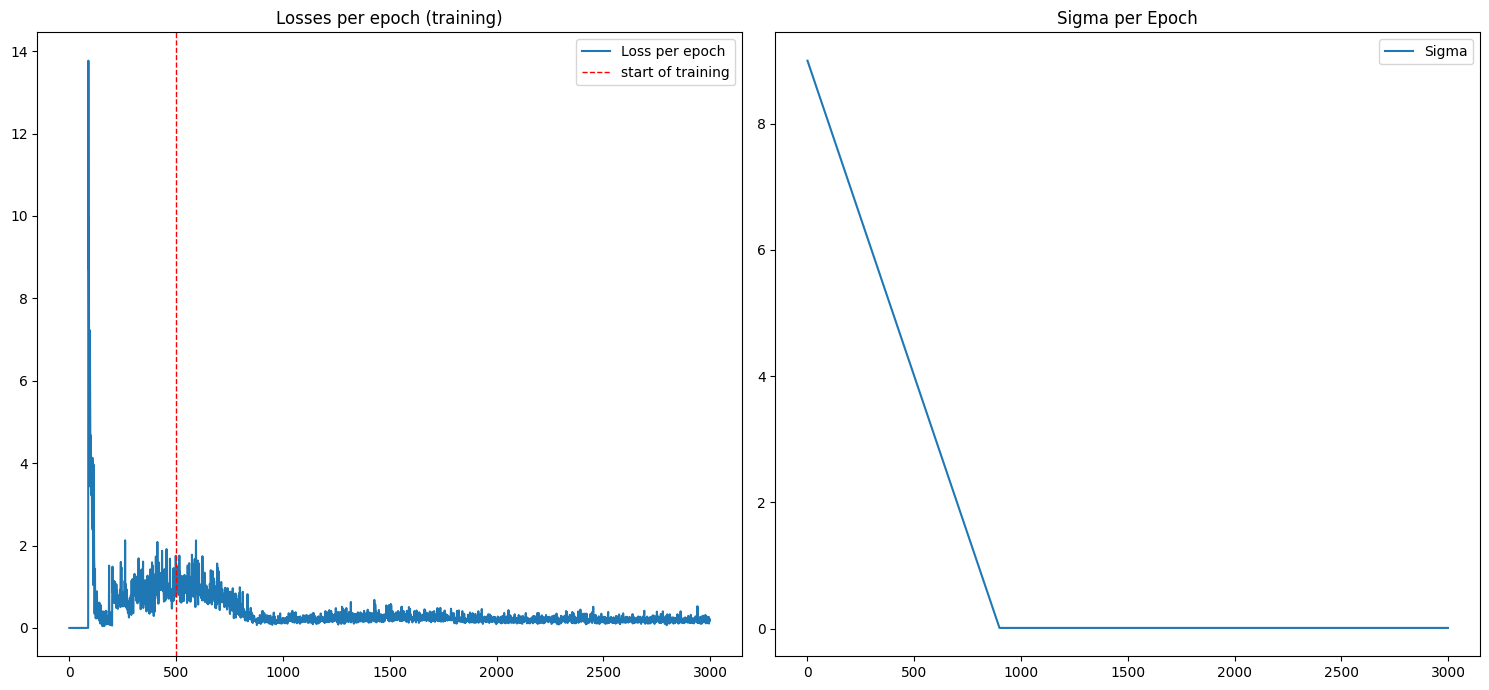

In [31]:
%matplotlib inline

# Créer une figure avec une taille personnalisée
plt.figure(figsize=(15, 7))

# Premier sous-graphe
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss per epoch')
plt.title('Losses per epoch (training)')
plt.axvline(x=start_training, color='r', linestyle='--', linewidth=1, label='start of training')
plt.legend()


# Troisième sous-graphe
plt.subplot(1, 2, 2)
# Exemple d'ajout d'un autre graphique, utilisez les données qui vous conviennent
plt.plot(sigma, label='Sigma')
plt.title('Sigma per Epoch')
plt.legend()

# Ajuster la mise en page pour éviter le chevauchement des éléments
plt.tight_layout()

# Afficher les graphiques
plt.show()


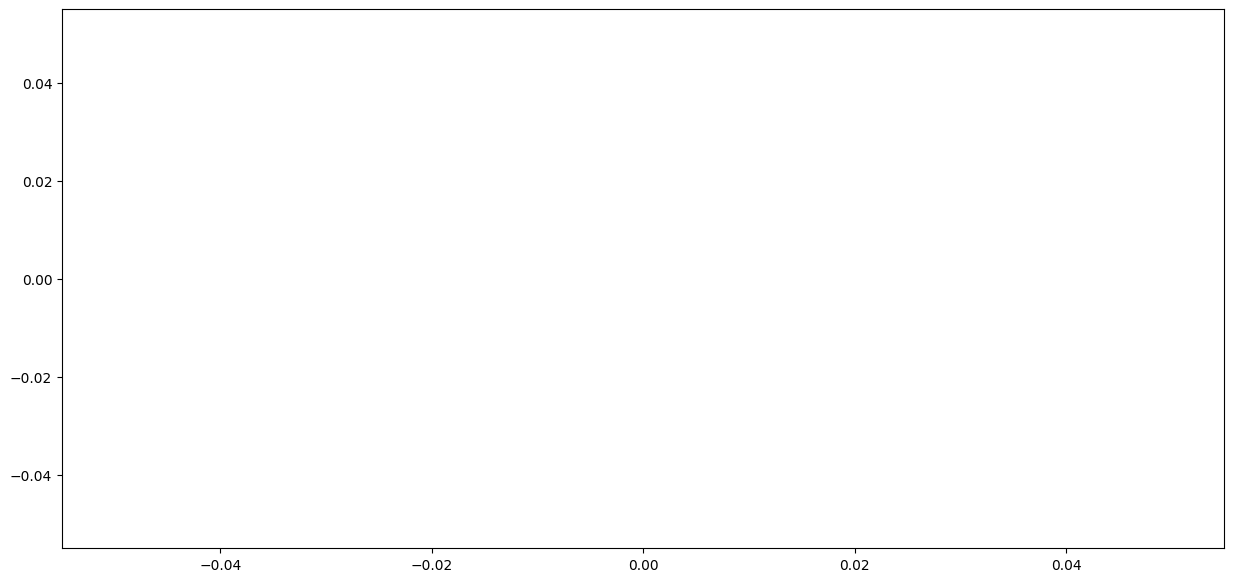

In [32]:
plt.figure(figsize=(15,7))
plt.plot(losses[10000:-1])

In [33]:
rewards_train = torch.tensor(reward_train)
n = rewards_train.shape[0]
history_mean = [torch.mean(rewards_train[i:i+100]) for i in range(1, n-100)]

In [34]:
rewards_train.shape

torch.Size([54116])

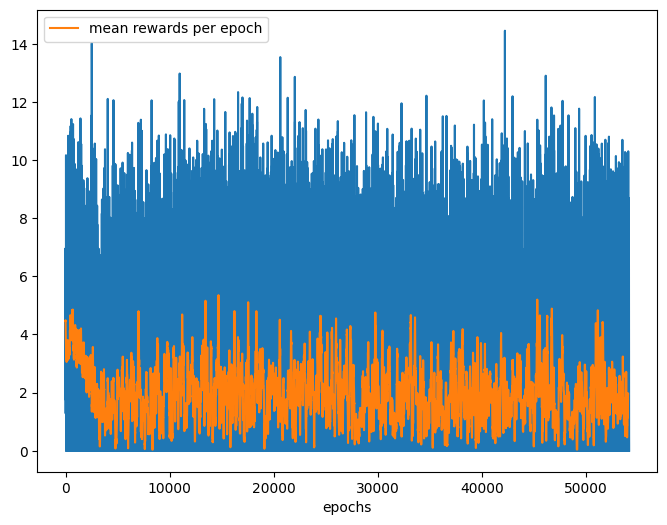

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(reward_train)
plt.plot(history_mean, label="mean rewards per epoch")
plt.xlabel("epochs")
plt.legend()

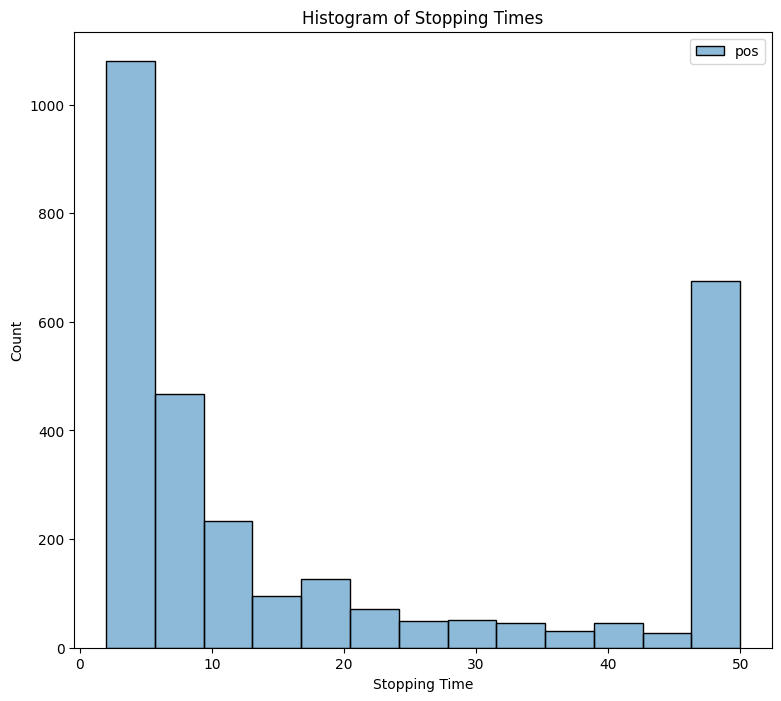

In [36]:
plt.figure(figsize=(9, 8))

df = pd.DataFrame({"pos": pos_train})

# Create the histplot with different colors for "exploit" and "explore"
sns.histplot(
    data=df,
)

# Add titles and labels
plt.title("Histogram of Stopping Times")
plt.xlabel("Stopping Time")
plt.ylabel("Count")

# Show the plot
plt.show()

In [37]:
history_mean[-1]

tensor(1.9679, dtype=torch.float64)

In [38]:
dqn_object.get_price(myagent,50,20000)

100%|██████████| 20000/20000 [02:29<00:00, 134.05it/s]


(6.58979752900857, 7.730489708881716, 5.449105349135424)

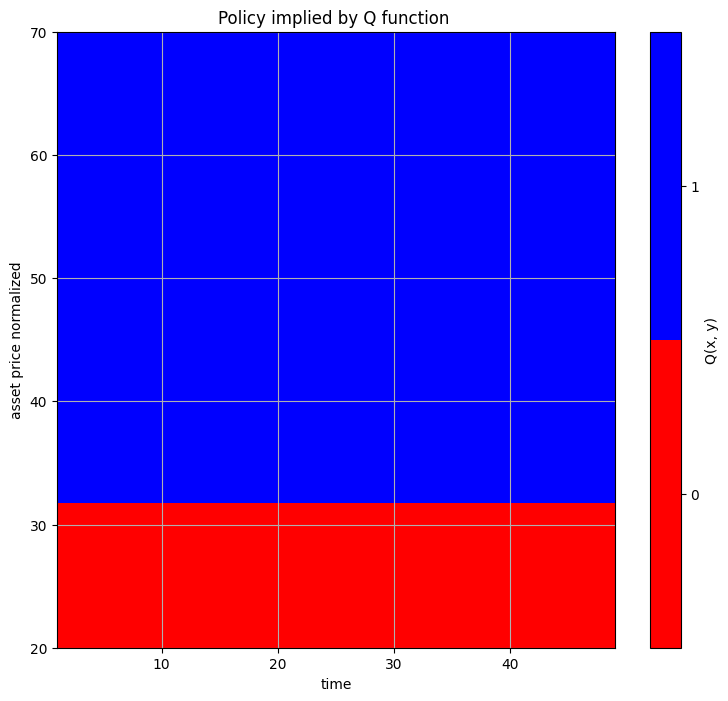

In [39]:
# Define the grid
y = np.linspace(20, 70, 50)
x = np.arange(1,50,1)
X, Y = np.meshgrid(x, y)

dt = maturity / n_simulation

myagent.continuing_network.eval()

def f(x, y):
    input_to_tensor = torch.tensor(np.array([x, y])).unsqueeze(0)
    Q_continuing = myagent.continuing_network(input_to_tensor)
    r_stopping = torch.exp(torch.tensor(-r*dt*x)) * put_option_payoff(y) 
    return int(Q_continuing - r_stopping > 0)


# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f(X[i, j], Y[i, j])

# Plot the results with specified colors
plt.figure(figsize=(9, 8))
plt.contourf(X, Y, Z, levels=[-0.5, 0.5, 1.5], colors=["red", "blue"])
plt.colorbar(ticks=[0, 1], label="Q(x, y)")
plt.title("Policy implied by Q function ")
plt.xlabel("time")
plt.ylabel("asset price normalized")
plt.grid()
plt.show()